## A/B–тестирование новой механики оплаты на сайте



В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# importing required libraries and packages

import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.stats import proportion
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import requests
from urllib.parse import urlencode

%matplotlib inline

In [2]:
# uploading data from Yandex with correct delimiter

# getting api base key
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# getting each csv-file public key
groups_public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
experiment_users_public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

# getting download urls
groups_final_url = base_url + urlencode(dict(public_key = groups_public_key))
groups_response = requests.get(groups_final_url)
groups_download_url = groups_response.json()['href']

experiment_users_final_url = base_url + urlencode(dict(public_key = experiment_users_public_key))
experiment_users_response = requests.get(experiment_users_final_url)
experiment_users_download_url = experiment_users_response.json()['href']

checks_final_url = base_url + urlencode(dict(public_key = checks_public_key))
checks_response = requests.get(checks_final_url)
checks_download_url = checks_response.json()['href']

# downloading and reading files
groups_download_response = requests.get(groups_download_url)
experiment_users_download_response = requests.get(experiment_users_download_url)
checks_download_response = requests.get(checks_download_url)

groups = pd.read_csv(groups_download_url, sep=';') 
experiment_users = pd.read_csv(experiment_users_download_url, sep=';') 
checks = pd.read_csv(checks_download_url, sep=';') 

In [3]:
# exploring raw data

groups.shape
groups.dtypes
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
experiment_users.shape
experiment_users.dtypes
experiment_users.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [5]:
checks.shape
checks.dtypes
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [6]:
# NaN-check

groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
experiment_users.isna().sum()

student_id    0
dtype: int64

In [8]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

За основу для анализа возьмём датафрейм с пользователями, которые заходили на платформу в дни эксперимента (так как если брать за основу, например, датафрейм с чеками, мы рискуем включить в анализ тех пользователей, которые оплачивали покупки, но не заходили на платформу или оплачивали покупки, но не были включены в систему сплитования и не получили свой маркер группы).

Приджойним к датафрейму с экспериментальными пользователями данные об их группах и покупках.

In [9]:
# merge raw data into a new dataframe 

experiment_data = experiment_users \
    .merge(groups, 
           left_on = 'student_id', 
           right_on = 'id', 
           how = 'inner')[['student_id', 'grp']] \
    .merge(checks, on = 'student_id', how = 'left')
experiment_data.head()

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


В качестве метрик для анализа возьмем **среднюю выручку на пользователя (ARPU)**, **средний чек (AOV)** (который в нашем случае будет равен ARPPU, что редкая ситуация на практике) и **конверсию в покупку (СR)**, так как эти метрики непосредственно влияют на объем вырученных компанией денег, а также поскольку именно эти метрики доступны нам для расчета из входных данных. **Целевой метрикой будем считать ARPU.**

In [10]:
# calculating metrics by creating new column for each metric

metrics_df = experiment_data \
    .groupby('grp', as_index = False) \
    .agg(revenue = ('rev', 'sum'), students_total_cnt = ('student_id', 'nunique'))

metrics_df['paying_students_cnt'] = experiment_data \
    .dropna() \
    .groupby('grp', as_index = False) \
    .agg(students_cnt = ('student_id', 'nunique')) \
    .students_cnt

metrics = metrics_df.assign(
    arpu = round(metrics_df.revenue / metrics_df.students_total_cnt, 3),
    cr = round(100 * metrics_df.paying_students_cnt / metrics_df.students_total_cnt, 3),
    aov = round(metrics_df.revenue / metrics_df.paying_students_cnt, 3)
    )
metrics

,grp,revenue,students_total_cnt,paying_students_cnt,arpu,cr,aov
0,A,72820.0000,1535,78,47.440,5.081,933.590
1,B,393074.0035,6793,313,57.865,4.608,1255.827


*Примечание: здесь я позволила себе для расчета среднего чека использовать количество платящих пользователей, так как в нашем случае AOV = ARPPU. Если бы наши данные были иной природы, мы бы разделяли эти две метрики и считали бы их по-разному: средний чек расчитывали бы, как выручку, деленную на количество транзакций, а ARPPU – как выручку, деленную на количество пользователей.*


В результате мы видим, что несмотря на сильно различающуюся выручку в группах, 
CR контрольной группы выше, чем в тестовой. Это может быть связано с выраженной асимметрией в объеме выборок.
В идеале я инициировала бы проверку сплит-системы, так как такие выраженные различия (почти в 4 раза) могут
свидетельствовать о неравновероятном попадании пользователей в группы.

Тем не менее, мы видим, что ARPU тестовой группы выше, чем в контроле, а также видим различия в среднем чеке. Исходя из соображения, что для компании такие различия могут оказаться существенными, будем проверять гипотезу о том, что эти метрикb в двух группах отличаются. Попутно протестируем другую гипотезу - о том, что CR в двух группах также статистически значимо различается.

##### Таким образом:

**Нуль-гипотеза №1**: Средние чеки в тестовой и контрольной группах не различаются.
**Альтернативная гипотеза №1**: Средние чеки тестовой и контрольной групп статистически различаются.

**Нуль-гипотеза №2**: ARPU тестовой и контрольной групп не различаются.
**Альтернативная гипотеза №2**: ARPU тестовой и контрольной групп статистически различаются.

**Нуль-гипотеза №3**: Конверсии в покупку в тестовой и контрольной группах не различаются. **Альтернативная гипотеза №3**: Конверсии в покупку в тестовой и контрольной группах статистически различаются.

In [11]:
# forming samples for analysis

group_1 = experiment_data.query('grp == "A"').rev.fillna(0)

group_2 = experiment_data.query('grp == "B"').rev.fillna(0)

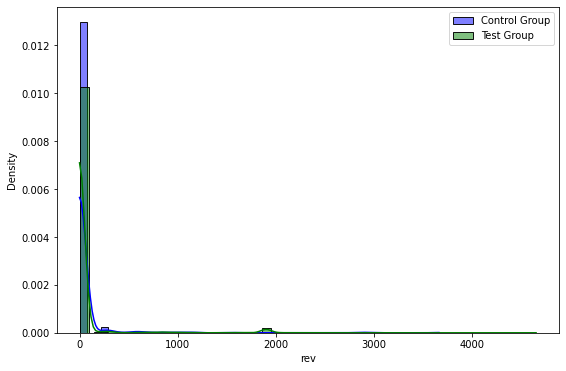

In [12]:
# samples distribution vizualization
# Видим сильно скошенные распределения в выборках, данные распределены ненормально, 
# что в целом ожидаемо, так как метрики обычно никогда не бывают нормально распределены

plt.figure(figsize=(9,6))
sns.histplot(group_1, bins=50, kde=True, color='blue', label='Control Group', stat='density')
sns.histplot(group_2, bins=50, kde=True, color='green', label='Test Group', stat='density')
plt.legend()

### Проверка гипотезы №1

Для проверки гипотезы о равенстве средних чеков воспользуемся bootstrap-анализом.

In [13]:
# forming samples for the 1st hypotesis
# используем наши искомые выборки, но оставим только данные о совершившихся оплатах (чеках)

group_1_1 = experiment_data.dropna().query('grp == "A"').rev
group_2_1 = experiment_data.dropna().query('grp == "B"').rev

In [14]:
# bootstrap function

def bootstrap_check(grp_1, grp_2):
    # creating list for mean diffs
    mean_diffs = []
    
    # generating bootstrapped samples
    for i in range(10000):
        boot_1 = grp_1.sample(frac = 1, replace = True)
        boot_2 = grp_2.sample(frac = 1, replace = True)
        mean_diffs.append(boot_1.mean() - boot_2.mean())
        
    # confidence interval
    lower = pd.Series(mean_diffs).quantile(0.025)
    upper = pd.Series(mean_diffs).quantile(0.975)
    
    return np.mean(mean_diffs), lower, upper

# bootstrap analysis
mean_diff_1, lower_result_1, upper_result_1 = bootstrap_check(group_1_1, group_2_1)

#results
print(f'Разница средних: {mean_diff_1}')
print(f'95% доверительный интервал: [{lower_result_1}, {upper_result_1}]')

# interpretation 
if lower_result_1 > 0 or upper_result_1 < 0:
    print('Разница статистически значима (95% доверительный интервал не включает 0)')
else:
    print('Разница статистически НЕ значима (95% доверительный интервал включает 0)')


Разница средних: -325.61341871438356
95% доверительный интервал: [-537.809630801794, -97.4833669269682]
Разница статистически значима (95% доверительный интервал не включает 0)


По результатам тестов видим, что уровень значимости меньше 0.05, а доверительный интервал не включает в себя 0, а значит, мы можем **отвергнуть нуль-гипотезу №1** о равенстве средних чеков в группах.

**Вывод: средние чеки в двух группах отличаются.**

### Проверка гипотезы №2

Для проверки гипотезы о равенстве средней выручки на пользователя обратимся так же bootstrap, но на вход подадим неочищенные от нулей выборки, которые сформировали выше

In [15]:
# bootstrap analysis
mean_diff_2, lower_result_2, upper_result_2 = bootstrap_check(group_1, group_2)

#results
print(f'Разница средних: {mean_diff_2}')
print(f'95% доверительный интервал: [{lower_result_2}, {upper_result_2}]')

# interpretation 
if lower_result_2 > 0 or upper_result_2 < 0:
    print('Разница статистически значима (95% доверительный интервал не включает 0).')
else:
    print('Разница статистически НЕ значима (95% доверительный интервал включает 0)')

Разница средних: -10.432992728252238
95% доверительный интервал: [-26.545046867434184, 6.361027742886308]
Разница статистически НЕ значима (95% доверительный интервал включает 0)


По результатам тестов видим, что уровень значимости выше 0.05, а доверительный интервал включает 0, а значит, мы **не можем отклонить нуль-гипотезу №2** о равенстве средней выручки на пользователя в двух группах.

**Вывод: ARPU в двух группах не отличается.**

Чем могут быть вызваны такие разногласия со средним чеком?
Возможно, пользователи стали покупать на большую сумму, но при этом доход на одного пользователя не увеличился, либо стало меньше покупок на меньшую сумму.

### Проверка гипотезы №3

Для проверки гипотезы о равенстве конверсий в наших выборках я использую критерий Хи-квадрат, так как переменная в данном случае – категориальная (купил / не купил).

In [16]:
# calculating number of purchases and total number of users in both groups
control_success = (group_1 > 0).sum()
test_success = (group_2 > 0).sum()

control_not_success = len(group_1) - control_success
test_not_success = len(group_2) - test_success

contingency_table = [[control_success, control_not_success],[test_success, test_not_success]]

chi2_stat, p_value, dof, expected = ss.chi2_contingency(contingency_table)

print(f"Chi2 Statistic = {chi2_stat}, p-value = {p_value}")

Chi2 Statistic = 0.526607176998989, p-value = 0.46803677583199144


Так как уровень значимости выше 0.05, мы **не можем отвергнуть нуль-гипотезу №3** о равенстве конверсий в группах.

**Вывод: конверсии в двух группах не различаются.**

#### ИТОГО:
- Конверсия в покупку **(СR)** и средняя выручка на пользователя **(ARPU) не претерпели изменений** в связи с запуском новой механики оплаты. 
- **Средний чек** (или, в нашем случае, средняя выручка на платящего пользователя) в тестовой группе **статистически значимо вырос** по сравнению с контрольной группой. Это может быть связано с тем, что покупок на мелкие суммы стало меньше, и пользователи стали покупать на более высокие суммы.
- Однако несмотря на этот прирост я бы **не рекомендовала выкатывать новую механику на всех пользователей**, так как целевая метрика (ARPU) не увеличилась, а значит, объем дохода не изменился, как это ни парадоксально звучит в контексте выросшего среднего чека. Более того, хоть изменения в конверсиях статистически оказались незначимы, мы видим небольшое снижение в тестовой группе. Анализ показывает, что это снижение носит случайный характер, но если брать во внимание четырёхкратную разницу в объёме выборок, я бы рекомендовала **проверить систему сплитования**, сформировать более однородные выборки и проанализировать конверсию вновь, чтобы понять, не ухудшает ли новая механика оплаты данную метрику. В этом случае конверсия выступает в качестве барьерной метрики, которая может просигнализировать о проблемах в результате эксперимента.

## Реализуем функции для обновления информации и создания графиков

В нашем случае нам прислали дополнительный файл с информацией о пользователях `groups_add.csv`. Необходимо реализовать функцию, которая будет автоматиечски подгружать эту информацию и на основании дополнительных параметров пересчитывать метрики.

In [17]:
# выносим ссылку на новый файл в глобальное окружение, 
# чтобы иметь возможность её менять и не хардкодить функцию

addition_file_public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

def metrics_update(df_1_groups, df_2_users, df_3_checks):
    
    # using Yandex api to download and read additional data
    new_final_url = base_url + urlencode(dict(public_key = addition_file_public_key)) 
    new_response = requests.get(new_final_url) 
    new_download_url = new_response.json()['href'] 

    new_download_response = requests.get(new_download_url) 
    groups_addition = pd.read_csv(new_download_url, sep=',') 

    # concatenate new data with the old one
    groups_new = pd.concat([df_1_groups, groups_addition], ignore_index = True)

    # creating new experimental dataframe by merging as we did before
    experiment_data_new = df_2_users \
        .merge(groups_new, 
               left_on = 'student_id', 
               right_on = 'id', 
               how = 'inner')[['student_id', 'grp']] \
        .merge(df_3_checks, on = 'student_id', how = 'left')
    
    # recalculate every metric
    metrics_df_new = experiment_data_new \
        .groupby('grp', as_index = False) \
        .agg(revenue = ('rev', 'sum'), 
             students_total_cnt = ('student_id', 'nunique'))

    metrics_df_new['paying_students'] = experiment_data_new \
        .dropna() \
        .groupby('grp', as_index = False) \
        .agg(students_cnt = ('student_id', 'nunique')) \
        .students_cnt

    metrics_new = metrics_df_new.assign(
    arpu = round(metrics_df_new.revenue / metrics_df_new.students_total_cnt, 3),
    cr = round(100 * metrics_df_new.paying_students / metrics_df_new.students_total_cnt, 3),
    aov = round(metrics_df_new.revenue / metrics_df_new.paying_students, 3)
    )
    
    return metrics_new

*Примечание: пока не до конца ясно, что делать в том случае, если пришлют еще один дополнительный файл. Это делает мою функцию всё же чуть более хардкодной, чем хотелось бы. Возможно, здесь нужно реализовывать функцию с неизвестным количеством агрументов.*

In [18]:
# checking if our function works correctly

new_metrics = metrics_update(groups, experiment_users, checks)
new_metrics

,grp,revenue,students_total_cnt,paying_students,arpu,cr,aov
0,A,72820.0000,1538,78,47.347,5.072,933.590
1,B,394974.0035,6803,314,58.059,4.616,1257.879


Видим, что метрики практически не изменились ввиду того, что в анализ добавилось всего 13 человек: это те самые пользователи, которые заходили на платформу в дни проведения эксперимента, но им не была присвоена какая-либо из групп. Теперь все пользователи, участвовавшие в эксперименте, задействованы в анализе, однако на метрики это не повлияло.

Реализуем функцию, которая будет строить графики по получаемым метрикам.

In [19]:
def metrics_plots(data):
    
    # we'll have 3 subplots, so to avoid writing the same settings 3 times, 
    # we will use the function to customize
    def plot_settings(ax, data, x, y, title):

        # settings for each subplot
        barplot = sns.barplot(data = data, x = x, y = y, ax = ax, palette = ["#4B49AC", "#98BDFF"])
        ax.set_title(f'{title}\n', fontsize = 25)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(labelsize = 17)
        sns.despine()

        # set concrete value lables for each bar
        for bar in barplot.patches:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (0.01 * height),
                f"{height:.2f}",
                ha = "center", va = "bottom", fontsize = 15
                   )
        return ax

    # set subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # create each subplot with some adjustments
    arpu_plot = plot_settings(axes[0], data, "grp", "arpu", "ARPU")
    arpu_plot.legend(('A - control group', 'B - test group'), prop = {'size': 15})

    cr_plot = plot_settings(axes[1], data, "grp", "cr", "CR")
    cr_plot.set_yticklabels([f"{int(tick)}%" for tick in cr_plot.get_yticks()])

    aov_plot = plot_settings(axes[2], data, "grp", "aov", "AOV")
    
    plt.tight_layout()
    plt.show()

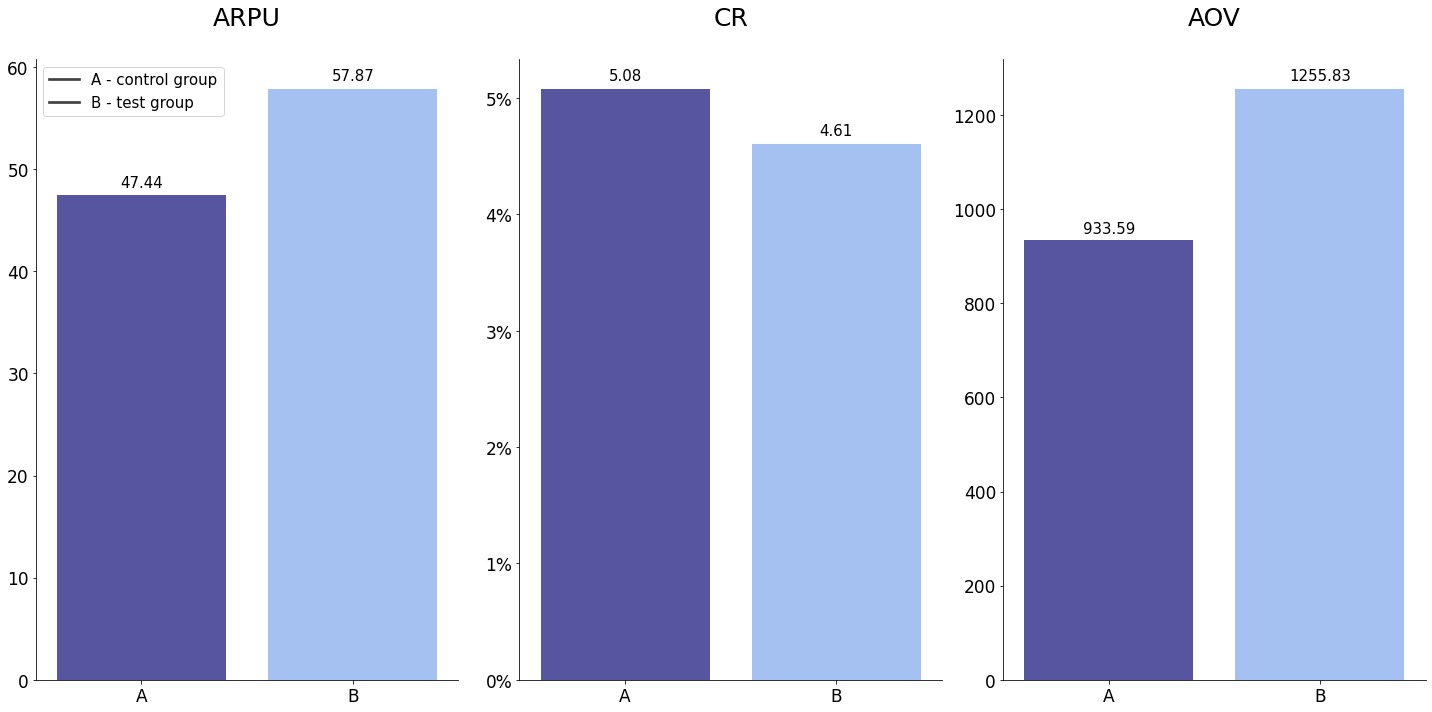

In [20]:
# checking if our function works correctly

metrics_plots(metrics)

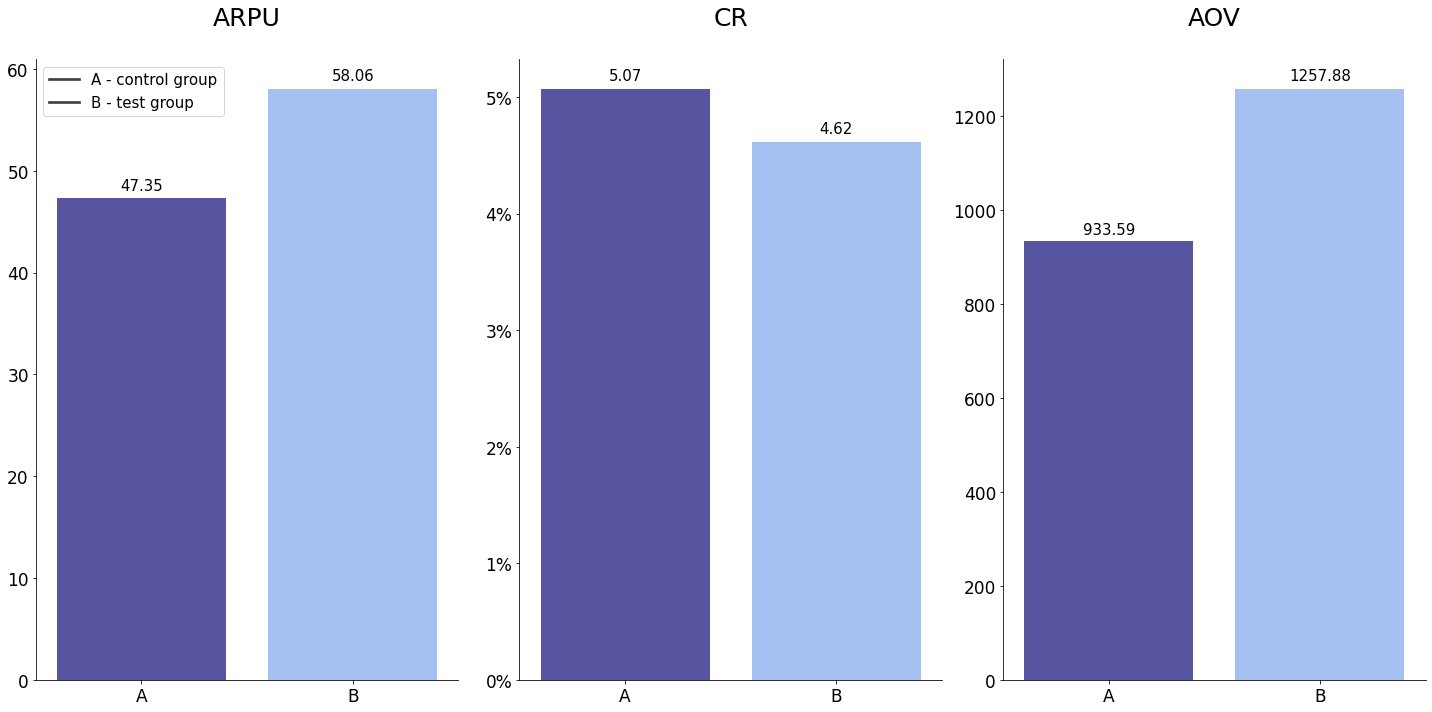

In [21]:
metrics_plots(new_metrics)